# Dynamic programming, with precalulation

From the book:

We first pre-calculate the table with 
$$
C(n,p) = \sum_{k=1}^{n} s(k)s(k+p)
$$

Then we approximate the exponent by, which is to be maximised:
$$
- \sum_{k=1}^{K} \sum_{n_k - 1}^{n_k - p_k} (s(n_k+p_k)-s(n))^2
$$

which is approximated by
$$
- 2 \sum_{n=1}^{40000} s(n)^2 + 2 \sum_{k=1}^{K}(C(n_k,p_k) - C(n_{k-1},p_k))
$$

Our objective is to $\textbf{minimise}$ the summation
$$
\sum_{k=1}^{K}(C(n_{k-1},p_k) - C(n_k,p_k))
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

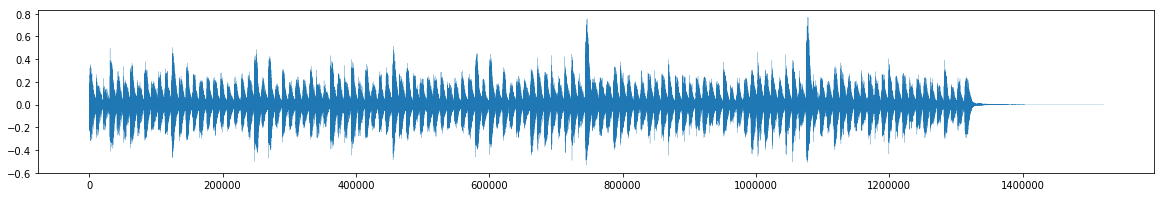

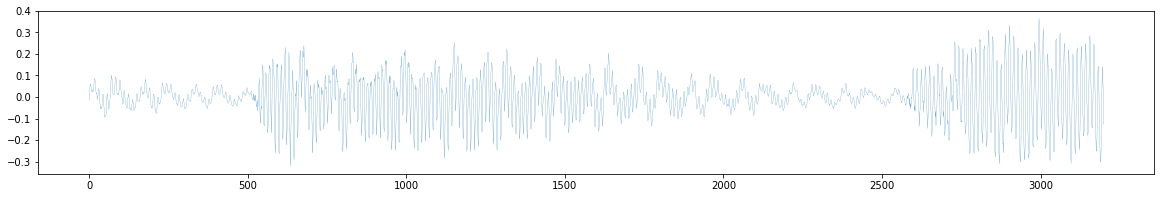

In [2]:
# signal = [np.sin(2*np.pi*x/4.01) for x in range(100)]

# signal1 = [np.sin(2*np.pi*x/3 + 0.1) for x in range(26)]
# signal2 = [np.sin(2*np.pi*x/4 + 0.2) for x in range(45)]
# signal3 = [np.sin(2*np.pi*x/5 + 0.3) for x in range(29)]

# signal = np.concatenate((signal1,signal2,signal3))

# signal += 0.1*np.random.randn(100)  # add noise

import os
import soundfile as sf
# read file
fileDir = os.path.dirname(os.path.realpath('__file__'))
file_name = os.path.join(fileDir, '../sounds/marsh mono.wav')
file_name = os.path.abspath(os.path.realpath(file_name))
ref, sample_rate = sf.read(file_name)

plt.figure(figsize=(20,3))
plt.plot(ref[:,0],lw=0.2)
plt.show()

signal = ref[132000:148000:5,0]

# print(signal)
plt.figure(figsize=(20,3))
plt.plot(signal,lw=0.2)
plt.show()

In [3]:
period_lower_range = 5
period_upper_range = 40

P = np.arange(period_lower_range, period_upper_range)  # list of periods

nll2 = np.zeros(len(signal)-period_upper_range)  # initialise list of nll2nents
nll2_t_ = np.zeros(len(signal)-period_upper_range)  # initialise list of nll2nents
nll2_p = np.zeros(len(signal)-period_upper_range)  # initialise list of nll2nents

## Precalculation
$$
C(n,p) = \sum_{k=1}^{n} s(k)s(k+p)
$$
Array index is not the actual period length, however:

`cee[n][p-cee_period_plot_start]` $ = C(n,p)$ 

Takes $p$ cummulative summation calcuations of length of the size of the snippet.

In [4]:
cee_time_plot_start = 0 # try 0
cee_time_plot_end = len(signal)-period_upper_range # try 2000
cee_time_plot_range = cee_time_plot_end - cee_time_plot_start
cee_period_plot_start = period_lower_range # try 0
cee_period_plot_end = period_upper_range # try 100
cee_period_plot_range = cee_period_plot_end - cee_period_plot_start

X = np.arange(cee_time_plot_start, cee_time_plot_end, 1)
Y = np.arange(cee_period_plot_start, cee_period_plot_end, 1)

cee = np.zeros((cee_time_plot_range, cee_period_plot_range))

# for t in range(signal_length):
for p in range(cee_period_plot_start, cee_period_plot_end):
    p_ = p - cee_period_plot_start  # array index is not actual period length
    # cumsum so that you do not need to calculate everything again and again
#     what is the difference between two square brackets and a comma in a square bracket?
#     print(np.multiply(signal[:cee_time_plot_end],
#                                     signal[p:cee_time_plot_end+p]))
#     print(np.multiply(signal[:cee_time_plot_end],
#                                     signal[p:cee_time_plot_end+p]))
    cee[:,p_] = np.cumsum(np.multiply(signal[:cee_time_plot_end],
                                    signal[p:cee_time_plot_end+p]))
    
# print(cee)
    

Minimise the nll (negative log-likelihood), for a given $t$ and $t'$ over $p$.  <br/>
Function returns the value of the minimum nll, and its corresponding $p$. <br/>
Takes $p$ addition calculations

In [5]:
def lel(t_,t,P):
    logexp_list_vary_p = []
    p_list = []
    
    for p in P:
        p = p-5
        if t_ + p < t:
            logexp_list_vary_p.append(cee[t,p] - cee[t_,p])
            p_list.append(p+3)
    arg_min = np.argmin(logexp_list_vary_p)
    return logexp_list_vary_p[arg_min] + 0.2, p_list[arg_min]

In [6]:
# # minimise over p, not using cee
# def lel(t_,t,P):
# #     print("\n{}~{}:".format(t_, t), end='')
    
#     logexp_list_vary_p = []
#     p_list = []
    
#     for p in P:
#         if t_ + p < t:
#             to_append = np.sum([(signal[k+p] - signal[k])**2 for k in range(t_,t-p)])
# #             print(" p{}-{:.3f}  ".format(p,to_append), end='')
#             logexp_list_vary_p.append(to_append)
#             p_list.append(p)
#     arg_min = np.argmin(logexp_list_vary_p)
#     return logexp_list_vary_p[arg_min] + 0.2, p_list[arg_min]

Minimise the nll (negative log-likelihood), for a given $t$ over $t'$ with its corresponding $p$.  <br/>
Function returns the value of the minimum nll, and its corresponding $t'$ and $p$. <br/>
Calls the nll function ($p$ calcuations) $t$ times - total of $pt$ times.

Build the nll from a low t (starting with zeroes). 
Calls the lol function $l$ times, calls the nll function a total of $\frac{1}{2} l^2 p$

### todo: split this into a function and a loop

In [7]:
for i in range(4,len(nll2)):
# for i in range(4,10):
    print("exp[{}]".format(i), end='')
    
    logexp_list_vary_t_ = []
    t__list = []
    p_min_list = []
    
    for t_ in range(i-3):
        value, p_min = lel(t_,i,P)
        logexp_list_vary_t_.append(value)
        t__list.append(t_)
        p_min_list.append(p_min)
        
    arg_min = np.argmin(np.add(logexp_list_vary_t_, nll2[:len(logexp_list_vary_t_)]))
    
    nll2[i] = nll2[arg_min] + logexp_list_vary_t_[arg_min]
    
    nll2_p[i] = p_min_list[arg_min]
    nll2_t_[i] = t__list[arg_min]
    print("\nminimum = {:5f} at t'={} and p={} \n".format(nll2[i], nll2_t_[i], nll2_p[i]))

exp[4]
minimum = 0.203878 at t'=0.0 and p=4.0 

exp[5]
minimum = 0.205497 at t'=1.0 and p=3.0 

exp[6]
minimum = 0.206016 at t'=2.0 and p=3.0 

exp[7]
minimum = 0.205269 at t'=3.0 and p=3.0 

exp[8]
minimum = 0.205982 at t'=3.0 and p=3.0 

exp[9]
minimum = 0.206818 at t'=3.0 and p=3.0 

exp[10]
minimum = 0.208322 at t'=3.0 and p=3.0 

exp[11]
minimum = 0.211075 at t'=3.0 and p=3.0 

exp[12]
minimum = 0.213048 at t'=0.0 and p=14.0 

exp[13]
minimum = 0.211175 at t'=0.0 and p=15.0 

exp[14]
minimum = 0.209834 at t'=0.0 and p=16.0 

exp[15]
minimum = 0.205503 at t'=0.0 and p=17.0 

exp[16]
minimum = 0.197505 at t'=0.0 and p=18.0 

exp[17]
minimum = 0.190321 at t'=0.0 and p=19.0 

exp[18]
minimum = 0.183373 at t'=0.0 and p=20.0 

exp[19]
minimum = 0.181251 at t'=1.0 and p=20.0 

exp[20]
minimum = 0.179281 at t'=3.0 and p=19.0 

exp[21]
minimum = 0.179266 at t'=3.0 and p=19.0 

exp[22]
minimum = 0.179494 at t'=3.0 and p=19.0 

exp[23]
minimum = 0.179703 at t'=3.0 and p=19.0 

exp[24]
minimu

exp[172]
minimum = -0.046020 at t'=0.0 and p=32.0 

exp[173]
minimum = -0.046775 at t'=0.0 and p=32.0 

exp[174]
minimum = -0.048794 at t'=0.0 and p=32.0 

exp[175]
minimum = -0.052665 at t'=0.0 and p=32.0 

exp[176]
minimum = -0.057970 at t'=0.0 and p=32.0 

exp[177]
minimum = -0.064139 at t'=0.0 and p=32.0 

exp[178]
minimum = -0.070119 at t'=0.0 and p=32.0 

exp[179]
minimum = -0.074537 at t'=0.0 and p=32.0 

exp[180]
minimum = -0.076677 at t'=0.0 and p=32.0 

exp[181]
minimum = -0.077405 at t'=0.0 and p=32.0 

exp[182]
minimum = -0.077518 at t'=0.0 and p=32.0 

exp[183]
minimum = -0.077534 at t'=0.0 and p=32.0 

exp[184]
minimum = -0.077534 at t'=0.0 and p=32.0 

exp[185]
minimum = -0.077487 at t'=0.0 and p=32.0 

exp[186]
minimum = -0.077342 at t'=0.0 and p=32.0 

exp[187]
minimum = -0.077509 at t'=0.0 and p=32.0 

exp[188]
minimum = -0.078109 at t'=0.0 and p=32.0 

exp[189]
minimum = -0.079084 at t'=0.0 and p=32.0 

exp[190]
minimum = -0.080147 at t'=0.0 and p=32.0 

exp[191]
min

exp[340]
minimum = -0.206422 at t'=0.0 and p=32.0 

exp[341]
minimum = -0.207456 at t'=0.0 and p=32.0 

exp[342]
minimum = -0.208079 at t'=0.0 and p=32.0 

exp[343]
minimum = -0.208384 at t'=0.0 and p=32.0 

exp[344]
minimum = -0.208547 at t'=0.0 and p=32.0 

exp[345]
minimum = -0.208662 at t'=0.0 and p=32.0 

exp[346]
minimum = -0.208695 at t'=0.0 and p=32.0 

exp[347]
minimum = -0.208874 at t'=0.0 and p=32.0 

exp[348]
minimum = -0.209231 at t'=0.0 and p=32.0 

exp[349]
minimum = -0.209774 at t'=0.0 and p=32.0 

exp[350]
minimum = -0.210364 at t'=0.0 and p=32.0 

exp[351]
minimum = -0.210933 at t'=0.0 and p=32.0 

exp[352]
minimum = -0.211235 at t'=0.0 and p=32.0 

exp[353]
minimum = -0.211256 at t'=0.0 and p=32.0 

exp[354]
minimum = -0.211374 at t'=0.0 and p=32.0 

exp[355]
minimum = -0.211798 at t'=0.0 and p=32.0 

exp[356]
minimum = -0.212611 at t'=0.0 and p=32.0 

exp[357]
minimum = -0.213622 at t'=0.0 and p=32.0 

exp[358]
minimum = -0.214688 at t'=0.0 and p=32.0 

exp[359]
min

exp[499]
minimum = -0.283700 at t'=0.0 and p=32.0 

exp[500]
minimum = -0.283760 at t'=0.0 and p=32.0 

exp[501]
minimum = -0.282747 at t'=0.0 and p=32.0 

exp[502]
minimum = -0.281104 at t'=0.0 and p=32.0 

exp[503]
minimum = -0.280647 at t'=0.0 and p=32.0 

exp[504]
minimum = -0.281041 at t'=0.0 and p=32.0 

exp[505]
minimum = -0.282289 at t'=0.0 and p=32.0 

exp[506]
minimum = -0.283478 at t'=0.0 and p=32.0 

exp[507]
minimum = -0.284694 at t'=0.0 and p=32.0 

exp[508]
minimum = -0.285228 at t'=0.0 and p=32.0 

exp[509]
minimum = -0.286074 at t'=0.0 and p=32.0 

exp[510]
minimum = -0.286141 at t'=0.0 and p=32.0 

exp[511]
minimum = -0.284797 at t'=0.0 and p=32.0 

exp[512]
minimum = -0.282798 at t'=0.0 and p=32.0 

exp[513]
minimum = -0.282489 at t'=0.0 and p=32.0 

exp[514]
minimum = -0.283781 at t'=0.0 and p=32.0 

exp[515]
minimum = -0.284213 at t'=0.0 and p=32.0 

exp[516]
minimum = -0.283816 at t'=0.0 and p=32.0 

exp[517]
minimum = -0.282219 at t'=0.0 and p=32.0 

exp[518]
min

exp[653]
minimum = -1.607485 at t'=466.0 and p=28.0 

exp[654]
minimum = -1.602189 at t'=466.0 and p=28.0 

exp[655]
minimum = -1.603031 at t'=466.0 and p=28.0 

exp[656]
minimum = -1.615594 at t'=466.0 and p=28.0 

exp[657]
minimum = -1.633596 at t'=523.0 and p=16.0 

exp[658]
minimum = -1.668455 at t'=523.0 and p=16.0 

exp[659]
minimum = -1.689137 at t'=523.0 and p=16.0 

exp[660]
minimum = -1.694013 at t'=523.0 and p=16.0 

exp[661]
minimum = -1.688784 at t'=523.0 and p=16.0 

exp[662]
minimum = -1.687217 at t'=523.0 and p=16.0 

exp[663]
minimum = -1.695016 at t'=523.0 and p=16.0 

exp[664]
minimum = -1.713107 at t'=466.0 and p=28.0 

exp[665]
minimum = -1.724512 at t'=466.0 and p=28.0 

exp[666]
minimum = -1.724274 at t'=466.0 and p=28.0 

exp[667]
minimum = -1.714657 at t'=466.0 and p=28.0 

exp[668]
minimum = -1.710953 at t'=466.0 and p=28.0 

exp[669]
minimum = -1.710917 at t'=466.0 and p=28.0 

exp[670]
minimum = -1.710867 at t'=466.0 and p=28.0 

exp[671]
minimum = -1.711534

exp[805]
minimum = -2.643743 at t'=466.0 and p=28.0 

exp[806]
minimum = -2.642434 at t'=466.0 and p=28.0 

exp[807]
minimum = -2.642500 at t'=466.0 and p=28.0 

exp[808]
minimum = -2.644907 at t'=466.0 and p=28.0 

exp[809]
minimum = -2.656420 at t'=466.0 and p=28.0 

exp[810]
minimum = -2.680060 at t'=466.0 and p=28.0 

exp[811]
minimum = -2.706089 at t'=466.0 and p=28.0 

exp[812]
minimum = -2.730547 at t'=466.0 and p=28.0 

exp[813]
minimum = -2.752450 at t'=466.0 and p=28.0 

exp[814]
minimum = -2.753499 at t'=466.0 and p=28.0 

exp[815]
minimum = -2.752560 at t'=466.0 and p=28.0 

exp[816]
minimum = -2.757898 at t'=466.0 and p=28.0 

exp[817]
minimum = -2.764491 at t'=466.0 and p=28.0 

exp[818]
minimum = -2.770267 at t'=466.0 and p=28.0 

exp[819]
minimum = -2.772083 at t'=466.0 and p=28.0 

exp[820]
minimum = -2.767639 at t'=466.0 and p=28.0 

exp[821]
minimum = -2.767103 at t'=466.0 and p=28.0 

exp[822]
minimum = -2.773103 at t'=466.0 and p=28.0 

exp[823]
minimum = -2.781817


exp[958]
minimum = -4.069335 at t'=466.0 and p=28.0 

exp[959]
minimum = -4.072731 at t'=466.0 and p=28.0 

exp[960]
minimum = -4.075908 at t'=466.0 and p=28.0 

exp[961]
minimum = -4.072961 at t'=466.0 and p=28.0 

exp[962]
minimum = -4.065468 at t'=466.0 and p=28.0 

exp[963]
minimum = -4.072183 at t'=466.0 and p=28.0 

exp[964]
minimum = -4.097637 at t'=466.0 and p=28.0 

exp[965]
minimum = -4.140370 at t'=466.0 and p=28.0 

exp[966]
minimum = -4.194840 at t'=466.0 and p=28.0 

exp[967]
minimum = -4.230358 at t'=466.0 and p=28.0 

exp[968]
minimum = -4.242864 at t'=466.0 and p=28.0 

exp[969]
minimum = -4.242728 at t'=466.0 and p=28.0 

exp[970]
minimum = -4.244766 at t'=466.0 and p=28.0 

exp[971]
minimum = -4.245067 at t'=466.0 and p=28.0 

exp[972]
minimum = -4.246454 at t'=466.0 and p=28.0 

exp[973]
minimum = -4.246477 at t'=466.0 and p=28.0 

exp[974]
minimum = -4.247066 at t'=466.0 and p=28.0 

exp[975]
minimum = -4.256312 at t'=466.0 and p=28.0 

exp[976]
minimum = -4.28039


exp[1109]
minimum = -5.778438 at t'=466.0 and p=28.0 

exp[1110]
minimum = -5.785761 at t'=466.0 and p=28.0 

exp[1111]
minimum = -5.785401 at t'=466.0 and p=28.0 

exp[1112]
minimum = -5.787117 at t'=466.0 and p=28.0 

exp[1113]
minimum = -5.790121 at t'=466.0 and p=28.0 

exp[1114]
minimum = -5.793436 at t'=466.0 and p=28.0 

exp[1115]
minimum = -5.794737 at t'=466.0 and p=28.0 

exp[1116]
minimum = -5.793736 at t'=466.0 and p=28.0 

exp[1117]
minimum = -5.799982 at t'=466.0 and p=28.0 

exp[1118]
minimum = -5.829279 at t'=466.0 and p=28.0 

exp[1119]
minimum = -5.878272 at t'=466.0 and p=28.0 

exp[1120]
minimum = -5.942935 at t'=466.0 and p=28.0 

exp[1121]
minimum = -6.000332 at t'=466.0 and p=28.0 

exp[1122]
minimum = -6.026885 at t'=466.0 and p=28.0 

exp[1123]
minimum = -6.031238 at t'=466.0 and p=28.0 

exp[1124]
minimum = -6.031679 at t'=466.0 and p=28.0 

exp[1125]
minimum = -6.032787 at t'=466.0 and p=28.0 

exp[1126]
minimum = -6.034035 at t'=466.0 and p=28.0 

exp[1127]

exp[1261]
minimum = -7.573173 at t'=466.0 and p=28.0 

exp[1262]
minimum = -7.573672 at t'=466.0 and p=28.0 

exp[1263]
minimum = -7.576473 at t'=466.0 and p=28.0 

exp[1264]
minimum = -7.577469 at t'=466.0 and p=28.0 

exp[1265]
minimum = -7.577651 at t'=466.0 and p=28.0 

exp[1266]
minimum = -7.585342 at t'=466.0 and p=28.0 

exp[1267]
minimum = -7.606965 at t'=466.0 and p=28.0 

exp[1268]
minimum = -7.633846 at t'=466.0 and p=28.0 

exp[1269]
minimum = -7.661174 at t'=466.0 and p=28.0 

exp[1270]
minimum = -7.674720 at t'=466.0 and p=28.0 

exp[1271]
minimum = -7.675821 at t'=466.0 and p=28.0 

exp[1272]
minimum = -7.675893 at t'=466.0 and p=28.0 

exp[1273]
minimum = -7.685540 at t'=466.0 and p=28.0 

exp[1274]
minimum = -7.713602 at t'=466.0 and p=28.0 

exp[1275]
minimum = -7.744750 at t'=466.0 and p=28.0 

exp[1276]
minimum = -7.768719 at t'=466.0 and p=28.0 

exp[1277]
minimum = -7.776845 at t'=466.0 and p=28.0 

exp[1278]
minimum = -7.777319 at t'=466.0 and p=28.0 

exp[1279]


exp[1412]
minimum = -8.795498 at t'=466.0 and p=28.0 

exp[1413]
minimum = -8.814780 at t'=466.0 and p=28.0 

exp[1414]
minimum = -8.824016 at t'=466.0 and p=28.0 

exp[1415]
minimum = -8.826975 at t'=466.0 and p=28.0 

exp[1416]
minimum = -8.826362 at t'=466.0 and p=28.0 

exp[1417]
minimum = -8.826418 at t'=466.0 and p=28.0 

exp[1418]
minimum = -8.826890 at t'=466.0 and p=28.0 

exp[1419]
minimum = -8.826529 at t'=466.0 and p=28.0 

exp[1420]
minimum = -8.829929 at t'=466.0 and p=28.0 

exp[1421]
minimum = -8.843545 at t'=466.0 and p=28.0 

exp[1422]
minimum = -8.864544 at t'=466.0 and p=28.0 

exp[1423]
minimum = -8.890476 at t'=466.0 and p=28.0 

exp[1424]
minimum = -8.916440 at t'=466.0 and p=28.0 

exp[1425]
minimum = -8.933820 at t'=466.0 and p=28.0 

exp[1426]
minimum = -8.940317 at t'=466.0 and p=28.0 

exp[1427]
minimum = -8.940046 at t'=466.0 and p=28.0 

exp[1428]
minimum = -8.937976 at t'=466.0 and p=28.0 

exp[1429]
minimum = -8.940814 at t'=466.0 and p=28.0 

exp[1430]



exp[1563]
minimum = -9.585906 at t'=466.0 and p=28.0 

exp[1564]
minimum = -9.591208 at t'=466.0 and p=28.0 

exp[1565]
minimum = -9.601017 at t'=466.0 and p=28.0 

exp[1566]
minimum = -9.613534 at t'=466.0 and p=28.0 

exp[1567]
minimum = -9.623272 at t'=466.0 and p=28.0 

exp[1568]
minimum = -9.628059 at t'=466.0 and p=28.0 

exp[1569]
minimum = -9.628722 at t'=466.0 and p=28.0 

exp[1570]
minimum = -9.627478 at t'=466.0 and p=28.0 

exp[1571]
minimum = -9.627361 at t'=466.0 and p=28.0 

exp[1572]
minimum = -9.627689 at t'=466.0 and p=28.0 

exp[1573]
minimum = -9.627337 at t'=466.0 and p=28.0 

exp[1574]
minimum = -9.630709 at t'=466.0 and p=28.0 

exp[1575]
minimum = -9.640332 at t'=466.0 and p=28.0 

exp[1576]
minimum = -9.656282 at t'=466.0 and p=28.0 

exp[1577]
minimum = -9.676218 at t'=466.0 and p=28.0 

exp[1578]
minimum = -9.697909 at t'=466.0 and p=28.0 

exp[1579]
minimum = -9.714029 at t'=466.0 and p=28.0 

exp[1580]
minimum = -9.722721 at t'=466.0 and p=28.0 

exp[1581]

exp[1712]
minimum = -10.212847 at t'=466.0 and p=28.0 

exp[1713]
minimum = -10.218864 at t'=466.0 and p=28.0 

exp[1714]
minimum = -10.227830 at t'=466.0 and p=28.0 

exp[1715]
minimum = -10.234812 at t'=466.0 and p=28.0 

exp[1716]
minimum = -10.237519 at t'=466.0 and p=28.0 

exp[1717]
minimum = -10.237491 at t'=466.0 and p=28.0 

exp[1718]
minimum = -10.237109 at t'=466.0 and p=28.0 

exp[1719]
minimum = -10.237703 at t'=466.0 and p=28.0 

exp[1720]
minimum = -10.240152 at t'=466.0 and p=28.0 

exp[1721]
minimum = -10.243251 at t'=466.0 and p=28.0 

exp[1722]
minimum = -10.245952 at t'=466.0 and p=28.0 

exp[1723]
minimum = -10.247383 at t'=466.0 and p=28.0 

exp[1724]
minimum = -10.247342 at t'=466.0 and p=28.0 

exp[1725]
minimum = -10.247043 at t'=466.0 and p=28.0 

exp[1726]
minimum = -10.247789 at t'=466.0 and p=28.0 

exp[1727]
minimum = -10.248778 at t'=466.0 and p=28.0 

exp[1728]
minimum = -10.248833 at t'=466.0 and p=28.0 

exp[1729]
minimum = -10.249473 at t'=466.0 and p

exp[1860]
minimum = -10.628472 at t'=466.0 and p=28.0 

exp[1861]
minimum = -10.628936 at t'=466.0 and p=28.0 

exp[1862]
minimum = -10.629338 at t'=466.0 and p=28.0 

exp[1863]
minimum = -10.629634 at t'=466.0 and p=28.0 

exp[1864]
minimum = -10.629670 at t'=466.0 and p=28.0 

exp[1865]
minimum = -10.630639 at t'=466.0 and p=28.0 

exp[1866]
minimum = -10.633866 at t'=466.0 and p=28.0 

exp[1867]
minimum = -10.640591 at t'=466.0 and p=28.0 

exp[1868]
minimum = -10.649546 at t'=466.0 and p=28.0 

exp[1869]
minimum = -10.658988 at t'=466.0 and p=28.0 

exp[1870]
minimum = -10.665950 at t'=466.0 and p=28.0 

exp[1871]
minimum = -10.670813 at t'=466.0 and p=28.0 

exp[1872]
minimum = -10.673366 at t'=466.0 and p=28.0 

exp[1873]
minimum = -10.674327 at t'=466.0 and p=28.0 

exp[1874]
minimum = -10.674575 at t'=466.0 and p=28.0 

exp[1875]
minimum = -10.673774 at t'=466.0 and p=28.0 

exp[1876]
minimum = -10.672331 at t'=466.0 and p=28.0 

exp[1877]
minimum = -10.671781 at t'=466.0 and p

exp[2007]
minimum = -10.865615 at t'=466.0 and p=28.0 

exp[2008]
minimum = -10.865318 at t'=466.0 and p=28.0 

exp[2009]
minimum = -10.864802 at t'=466.0 and p=28.0 

exp[2010]
minimum = -10.865113 at t'=466.0 and p=28.0 

exp[2011]
minimum = -10.866251 at t'=466.0 and p=28.0 

exp[2012]
minimum = -10.867292 at t'=466.0 and p=28.0 

exp[2013]
minimum = -10.868042 at t'=466.0 and p=28.0 

exp[2014]
minimum = -10.867924 at t'=466.0 and p=28.0 

exp[2015]
minimum = -10.866899 at t'=466.0 and p=28.0 

exp[2016]
minimum = -10.865908 at t'=466.0 and p=28.0 

exp[2017]
minimum = -10.865522 at t'=466.0 and p=28.0 

exp[2018]
minimum = -10.865396 at t'=466.0 and p=28.0 

exp[2019]
minimum = -10.865300 at t'=466.0 and p=28.0 

exp[2020]
minimum = -10.865549 at t'=466.0 and p=28.0 

exp[2021]
minimum = -10.867580 at t'=466.0 and p=28.0 

exp[2022]
minimum = -10.872174 at t'=466.0 and p=28.0 

exp[2023]
minimum = -10.878328 at t'=466.0 and p=28.0 

exp[2024]
minimum = -10.884861 at t'=466.0 and p

exp[2154]
minimum = -11.036874 at t'=466.0 and p=28.0 

exp[2155]
minimum = -11.036484 at t'=466.0 and p=28.0 

exp[2156]
minimum = -11.035918 at t'=466.0 and p=28.0 

exp[2157]
minimum = -11.035447 at t'=466.0 and p=28.0 

exp[2158]
minimum = -11.035726 at t'=466.0 and p=28.0 

exp[2159]
minimum = -11.036975 at t'=466.0 and p=28.0 

exp[2160]
minimum = -11.038729 at t'=466.0 and p=28.0 

exp[2161]
minimum = -11.039783 at t'=466.0 and p=28.0 

exp[2162]
minimum = -11.040193 at t'=466.0 and p=28.0 

exp[2163]
minimum = -11.039813 at t'=466.0 and p=28.0 

exp[2164]
minimum = -11.039274 at t'=466.0 and p=28.0 

exp[2165]
minimum = -11.038971 at t'=466.0 and p=28.0 

exp[2166]
minimum = -11.038983 at t'=466.0 and p=28.0 

exp[2167]
minimum = -11.038935 at t'=466.0 and p=28.0 

exp[2168]
minimum = -11.038648 at t'=466.0 and p=28.0 

exp[2169]
minimum = -11.038329 at t'=466.0 and p=28.0 

exp[2170]
minimum = -11.038202 at t'=466.0 and p=28.0 

exp[2171]
minimum = -11.038423 at t'=466.0 and p


exp[2303]
minimum = -11.129075 at t'=466.0 and p=28.0 

exp[2304]
minimum = -11.131119 at t'=466.0 and p=28.0 

exp[2305]
minimum = -11.132634 at t'=466.0 and p=28.0 

exp[2306]
minimum = -11.133552 at t'=466.0 and p=28.0 

exp[2307]
minimum = -11.133888 at t'=466.0 and p=28.0 

exp[2308]
minimum = -11.133962 at t'=466.0 and p=28.0 

exp[2309]
minimum = -11.133973 at t'=466.0 and p=28.0 

exp[2310]
minimum = -11.133889 at t'=466.0 and p=28.0 

exp[2311]
minimum = -11.133761 at t'=466.0 and p=28.0 

exp[2312]
minimum = -11.133914 at t'=466.0 and p=28.0 

exp[2313]
minimum = -11.134424 at t'=466.0 and p=28.0 

exp[2314]
minimum = -11.135403 at t'=466.0 and p=28.0 

exp[2315]
minimum = -11.136652 at t'=466.0 and p=28.0 

exp[2316]
minimum = -11.137666 at t'=466.0 and p=28.0 

exp[2317]
minimum = -11.138300 at t'=466.0 and p=28.0 

exp[2318]
minimum = -11.138302 at t'=466.0 and p=28.0 

exp[2319]
minimum = -11.137973 at t'=466.0 and p=28.0 

exp[2320]
minimum = -11.137491 at t'=466.0 and 

exp[2452]
minimum = -11.190893 at t'=466.0 and p=28.0 

exp[2453]
minimum = -11.190980 at t'=466.0 and p=28.0 

exp[2454]
minimum = -11.191124 at t'=466.0 and p=28.0 

exp[2455]
minimum = -11.191233 at t'=466.0 and p=28.0 

exp[2456]
minimum = -11.191403 at t'=466.0 and p=28.0 

exp[2457]
minimum = -11.191636 at t'=466.0 and p=28.0 

exp[2458]
minimum = -11.191924 at t'=466.0 and p=28.0 

exp[2459]
minimum = -11.192284 at t'=466.0 and p=28.0 

exp[2460]
minimum = -11.192351 at t'=466.0 and p=28.0 

exp[2461]
minimum = -11.192325 at t'=466.0 and p=28.0 

exp[2462]
minimum = -11.192209 at t'=466.0 and p=28.0 

exp[2463]
minimum = -11.192137 at t'=466.0 and p=28.0 

exp[2464]
minimum = -11.192292 at t'=466.0 and p=28.0 

exp[2465]
minimum = -11.192626 at t'=466.0 and p=28.0 

exp[2466]
minimum = -11.193161 at t'=466.0 and p=28.0 

exp[2467]
minimum = -11.193882 at t'=466.0 and p=28.0 

exp[2468]
minimum = -11.194514 at t'=466.0 and p=28.0 

exp[2469]
minimum = -11.195084 at t'=466.0 and p


exp[2599]
minimum = -11.195656 at t'=466.0 and p=28.0 

exp[2600]
minimum = -11.195910 at t'=466.0 and p=28.0 

exp[2601]
minimum = -11.193676 at t'=466.0 and p=28.0 

exp[2602]
minimum = -11.191388 at t'=466.0 and p=28.0 

exp[2603]
minimum = -11.190591 at t'=466.0 and p=28.0 

exp[2604]
minimum = -11.192985 at t'=466.0 and p=28.0 

exp[2605]
minimum = -11.198333 at t'=466.0 and p=28.0 

exp[2606]
minimum = -11.197886 at t'=466.0 and p=28.0 

exp[2607]
minimum = -11.195157 at t'=466.0 and p=28.0 

exp[2608]
minimum = -11.188685 at t'=466.0 and p=28.0 

exp[2609]
minimum = -11.182937 at t'=466.0 and p=28.0 

exp[2610]
minimum = -11.181146 at t'=466.0 and p=28.0 

exp[2611]
minimum = -11.186428 at t'=466.0 and p=28.0 

exp[2612]
minimum = -11.191339 at t'=466.0 and p=28.0 

exp[2613]
minimum = -11.194360 at t'=466.0 and p=28.0 

exp[2614]
minimum = -11.196111 at t'=466.0 and p=28.0 

exp[2615]
minimum = -11.191657 at t'=466.0 and p=28.0 

exp[2616]
minimum = -11.187093 at t'=466.0 and 

exp[2745]
minimum = -12.474087 at t'=2410.0 and p=31.0 

exp[2746]
minimum = -12.469631 at t'=2410.0 and p=31.0 

exp[2747]
minimum = -12.471591 at t'=2410.0 and p=31.0 

exp[2748]
minimum = -12.483526 at t'=2410.0 and p=31.0 

exp[2749]
minimum = -12.510216 at t'=2410.0 and p=31.0 

exp[2750]
minimum = -12.529393 at t'=2410.0 and p=31.0 

exp[2751]
minimum = -12.546862 at t'=2410.0 and p=31.0 

exp[2752]
minimum = -12.547591 at t'=2410.0 and p=31.0 

exp[2753]
minimum = -12.553973 at t'=2410.0 and p=31.0 

exp[2754]
minimum = -12.577141 at t'=2410.0 and p=31.0 

exp[2755]
minimum = -12.626949 at t'=2410.0 and p=31.0 

exp[2756]
minimum = -12.680822 at t'=2410.0 and p=31.0 

exp[2757]
minimum = -12.717671 at t'=2410.0 and p=31.0 

exp[2758]
minimum = -12.744282 at t'=2410.0 and p=31.0 

exp[2759]
minimum = -12.742400 at t'=2410.0 and p=31.0 

exp[2760]
minimum = -12.743087 at t'=2410.0 and p=31.0 

exp[2761]
minimum = -12.753059 at t'=2410.0 and p=31.0 

exp[2762]
minimum = -12.787676 


exp[2890]
minimum = -16.539229 at t'=2410.0 and p=31.0 

exp[2891]
minimum = -16.570149 at t'=2410.0 and p=31.0 

exp[2892]
minimum = -16.580864 at t'=2410.0 and p=31.0 

exp[2893]
minimum = -16.579065 at t'=2410.0 and p=31.0 

exp[2894]
minimum = -16.586841 at t'=2410.0 and p=31.0 

exp[2895]
minimum = -16.599965 at t'=2410.0 and p=31.0 

exp[2896]
minimum = -16.629031 at t'=2410.0 and p=31.0 

exp[2897]
minimum = -16.642084 at t'=2410.0 and p=31.0 

exp[2898]
minimum = -16.645573 at t'=2410.0 and p=31.0 

exp[2899]
minimum = -16.646300 at t'=2410.0 and p=31.0 

exp[2900]
minimum = -16.680879 at t'=2410.0 and p=31.0 

exp[2901]
minimum = -16.732594 at t'=2410.0 and p=31.0 

exp[2902]
minimum = -16.825744 at t'=2410.0 and p=31.0 

exp[2903]
minimum = -16.913814 at t'=2410.0 and p=31.0 

exp[2904]
minimum = -16.973657 at t'=2410.0 and p=31.0 

exp[2905]
minimum = -17.003197 at t'=2410.0 and p=31.0 

exp[2906]
minimum = -17.005600 at t'=2410.0 and p=31.0 

exp[2907]
minimum = -17.008763


exp[3036]
minimum = -20.922734 at t'=2410.0 and p=31.0 

exp[3037]
minimum = -20.934800 at t'=2410.0 and p=31.0 

exp[3038]
minimum = -20.930180 at t'=2410.0 and p=31.0 

exp[3039]
minimum = -20.928938 at t'=2410.0 and p=31.0 

exp[3040]
minimum = -20.958147 at t'=2410.0 and p=31.0 

exp[3041]
minimum = -21.012506 at t'=2410.0 and p=31.0 

exp[3042]
minimum = -21.076097 at t'=2410.0 and p=31.0 

exp[3043]
minimum = -21.137001 at t'=2410.0 and p=31.0 

exp[3044]
minimum = -21.164388 at t'=2410.0 and p=31.0 

exp[3045]
minimum = -21.166890 at t'=2410.0 and p=31.0 

exp[3046]
minimum = -21.168793 at t'=2410.0 and p=31.0 

exp[3047]
minimum = -21.192599 at t'=2410.0 and p=31.0 

exp[3048]
minimum = -21.234499 at t'=2410.0 and p=31.0 

exp[3049]
minimum = -21.290511 at t'=2410.0 and p=31.0 

exp[3050]
minimum = -21.343062 at t'=2410.0 and p=31.0 

exp[3051]
minimum = -21.361516 at t'=2410.0 and p=31.0 

exp[3052]
minimum = -21.365232 at t'=2410.0 and p=31.0 

exp[3053]
minimum = -21.367116

In [8]:
# traceback algorithm
t_list = []
p_list = []

k = int(len(nll2_t_) - 1)

while True:
    t_list.append(k)
    p_list.append(nll2_p[k])
    k = int(nll2_t_[k])  # go to the previous t_
    # when we reach the start we stop the loop
    if k == 0:
        t_list.append(k)
        break

t_list = t_list[::-1] # to reverse the list
p_list = p_list[::-1]
print(t_list)
print(p_list)

[0, 466, 2410, 3159]
[32.0, 28.0, 31.0]


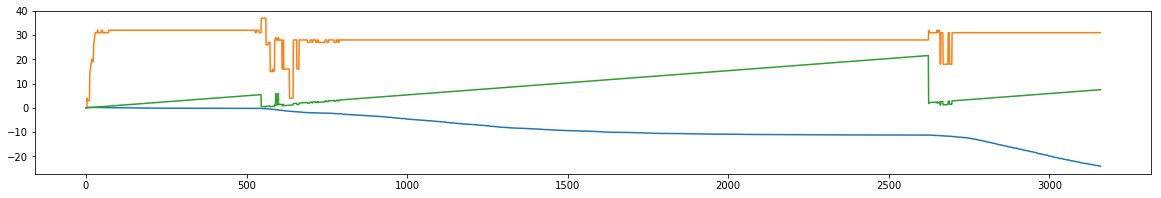

In [9]:
plt.figure(figsize=(20,3))
plt.plot(nll2)
plt.plot(nll2_p)
plt.plot(0.01*(np.arange(len(signal)-period_upper_range)-nll2_t_))
plt.show()

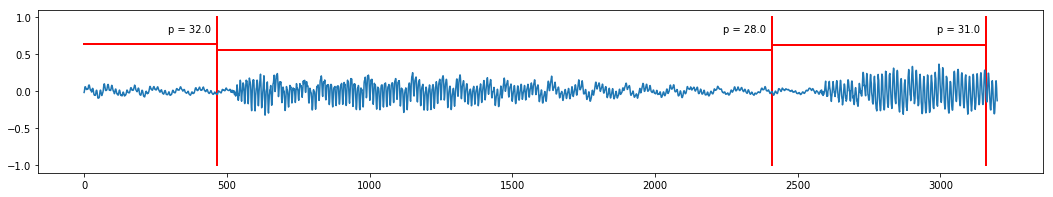

In [10]:
plt.figure(figsize=(18,3))
for k in range(len(p_list)):
    plt.plot([t_list[k+1], t_list[k+1]], [-1, 1], color='r', linestyle='-', linewidth=2)
    plt.plot([t_list[k], t_list[k+1]], [0.02*p_list[k], 0.02*p_list[k]], color='r', linestyle='-', linewidth=2)
    plt.text(t_list[k+1], 0.8, "p = {}  ".format(p_list[k]), horizontalalignment='right')
plt.plot(signal)
plt.show()